# Recolección y preprocesamiento de datos

## Imports

In [ ]:
# Importar librerias
from pathlib import Path
from scipy.io import wavfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt, IPython.display as ipd
import librosa, librosa.display
from librosa.util import normalize, fix_length
from scipy.signal import butter
from scipy.signal import filtfilt
from keras.utils import to_categorical

In [ ]:
!pip install noisereduce
import noisereduce as nr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Parametros

In [ ]:
# Frecuencia de muestreo
fs = 44100
# Definir el umbral de silencio en dB
top_db = 20

#Definir los parámetros para el espectrograma de mel
n_fft_parameter = int(0.025 * fs) # 25 ms en muestras
hop_length_parameter = int(n_fft_parameter/2) # 10 ms en muestras
n_mels_parameter = 40

## Lectura de archivos

In [ ]:
# leer los archivos y guardarlos
empezar_signals = [librosa.load(p)[0] for p in Path().glob('drive/MyDrive/Audios Señales/Empezar/Empezar_*.wav')]
empezar_labels = [0] * len(empezar_signals)

girar_signals = [librosa.load(p)[0] for p in Path().glob('drive/MyDrive/Audios Señales/Girar/Girar_*.wav')]
girar_labels = [1] * len(girar_signals)

leprechaun_signals = [librosa.load(p)[0] for p in Path().glob('drive/MyDrive/Audios Señales/Leprechaun/Leprechaun_*.wav')]
leprechaun_labels = [2] * len(leprechaun_signals)

mas_signals = [librosa.load(p)[0] for p in Path().glob('drive/MyDrive/Audios Señales/Mas/Mas_*.wav')]
mas_labels = [3] * len(mas_signals)

menos_signals = [librosa.load(p)[0] for p in Path().glob('drive/MyDrive/Audios Señales/Menos/Menos_*.wav')]
menos_labels = [4] * len(menos_signals)

# soltar_signals = [librosa.load(p)[0] for p in Path().glob('drive/MyDrive/Audios Señales/Soltar/Soltar_*.wav')]
# soltar_labels = [5] * len(soltar_signals)

# combinar señales y etiquetas
labels = np.array(empezar_labels + girar_labels + leprechaun_labels + mas_labels + menos_labels)

In [ ]:
labels = labels.reshape(-1, 1)
print(labels.shape)

(665, 1)


In [ ]:
labels_categorical = to_categorical(labels, 5)

## Funciones

In [ ]:
def preprocesamiento(signals):
  # Quitar silencios
  signals_trimmed = []
  for signal in signals:
      trimmed_signal, index = librosa.effects.trim(signal, top_db=top_db)
      signals_trimmed.append(trimmed_signal)

  # Normalizar las señales de audio
  signals_norm = []
  for signal in signals_trimmed:
    normalized_noise_reduced = nr.reduce_noise(signal, sr=fs)
    normalized_signal = normalize(normalized_noise_reduced)
    signals_norm.append(normalized_signal)

  #Encontrar la señal de audio de mayor tamaño
  max_len = 0
  for signal in signals_norm:
    length_signal = len(signal)
    if length_signal > max_len:
      max_len = length_signal

  #Hacer que todas las señales tengan el mismo tamaño
  signals_fixed = []
  for signal in signals_norm:
    fixed_signal = fix_length(signal, size=max_len)
    signals_fixed.append(fixed_signal)

  return signals_fixed

In [ ]:
def extract_features(signals_fixed):
  features = []
  for signal in signals_fixed:

    melspec = librosa.feature.melspectrogram(y =signal, sr=fs, power=2, n_mels=n_mels_parameter, center=False, hop_length=hop_length_parameter, n_fft=n_fft_parameter)
    melspecM = np.mean(melspec.T, axis=0)

    melspec_db = librosa.power_to_db(melspec, ref=np.max)

    chroma = librosa.feature.chroma_stft(S=melspec_db, sr=fs)
    chromaP = np.mean(chroma.T, axis=0)

    mfcc = librosa.feature.mfcc(y=signal, n_mfcc=13)
    mfccM = np.mean(mfcc.T, axis=0)
    delta_mfcc = librosa.feature.delta(mfcc)
    delta_mfccM = np.mean(delta_mfcc.T, axis=0)
    delta_mfcc2 = librosa.feature.delta(mfcc, order=2)
    delta_mfcc2M = np.mean(delta_mfcc2.T, axis=0)

    features_signal = np.reshape(melspecM, (1, -1))
    #features_signal = np.concatenate([mfccM, delta_mfccM, delta_mfcc2M, melspecM])
    features_signal = np.hstack([mfccM, delta_mfccM, delta_mfcc2M, melspecM])
    #features_signal = np.reshape(features_signal, (1, 79))
    features_signal = np.expand_dims(features_signal, axis=0)

    features.append(features_signal)

  return features

## Preprocesamiento

In [ ]:
#Empezar
empezar_signals_fixed = preprocesamiento(empezar_signals)
empezar_features = extract_features(empezar_signals_fixed)

In [ ]:
#Girar
girar_signals_fixed = preprocesamiento(girar_signals)
girar_features = extract_features(girar_signals_fixed)

In [ ]:
#Leprechaun
leprechaun_signals_fixed = preprocesamiento(leprechaun_signals)
leprechaun_features = extract_features(leprechaun_signals_fixed)

In [ ]:
#Mas
mas_signals_fixed = preprocesamiento(mas_signals)
mas_features = extract_features(mas_signals_fixed)

In [ ]:
#Menos
menos_signals_fixed = preprocesamiento(menos_signals)
menos_features = extract_features(menos_signals_fixed)

In [ ]:
# #Soltar
# soltar_signals_fixed = preprocesamiento(soltar_signals)
# soltar_features = extract_features(soltar_signals_fixed)

### Escalamiento de Características

In [ ]:
# # Aquí hacen en el ejemplo una unión en una misma tabla de los features de todas las categorías
# feature_table = np.vstack((empezar_features, girar_features, leprechaun_features, mas_features, menos_features, soltar_features)) # Apila arrays de manera vertical
# feature_table_reduce = np.squeeze(feature_table, axis=1)
# print(feature_table_reduce.shape) # El resultado es: Total datos, cantidad de características

In [ ]:
# Aquí hacen en el ejemplo una unión en una misma tabla de los features de todas las categorías
feature_table = np.vstack((empezar_features, girar_features, leprechaun_features, mas_features, menos_features)) # Apila arrays de manera vertical
feature_table_reduce = np.squeeze(feature_table, axis=1)
print(feature_table_reduce.shape) # El resultado es: Total datos, cantidad de características

(665, 79)


# Dataset

## Imports


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras import regularizers
from sklearn import metrics
from sklearn.metrics import precision_score
from keras.callbacks import ModelCheckpoint
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

## Particionamiento

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(feature_table_reduce, labels_categorical, test_size=0.2, random_state=180, stratify=labels_categorical)
batch_size =len(x_train)

print(x_train.shape, y_train.shape, y_test.shape )

(532, 79) (532, 5) (133, 5)


In [ ]:
x_train_P, x_test_P, y_train_P, y_test_P = train_test_split(feature_table_reduce, labels, test_size=0.2, random_state=180, stratify=labels)
y_train_P = y_train_P.ravel()
y_test_P = y_test_P.ravel()
batch_size =len(x_train)

print(x_train_P.shape, y_train_P.shape, y_test_P.shape )

(532, 79) (532,) (133,)


## Visualización del dataset

In [ ]:
df_dataset = pd.DataFrame(feature_table_reduce)
df_dataset.info()
total = df_dataset.isnull().sum().sort_values(ascending=False)
percent_1 = df_dataset.isnull().sum()/df_dataset.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(df_dataset.size)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 665 entries, 0 to 664
Data columns (total 79 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       665 non-null    float32
 1   1       665 non-null    float32
 2   2       665 non-null    float32
 3   3       665 non-null    float32
 4   4       665 non-null    float32
 5   5       665 non-null    float32
 6   6       665 non-null    float32
 7   7       665 non-null    float32
 8   8       665 non-null    float32
 9   9       665 non-null    float32
 10  10      665 non-null    float32
 11  11      665 non-null    float32
 12  12      665 non-null    float32
 13  13      665 non-null    float32
 14  14      665 non-null    float32
 15  15      665 non-null    float32
 16  16      665 non-null    float32
 17  17      665 non-null    float32
 18  18      665 non-null    float32
 19  19      665 non-null    float32
 20  20      665 non-null    float32
 21  21      665 non-null    float32
 22  22

,Total,%
0,0,0.0
50,0,0.0
57,0,0.0
56,0,0.0
55,0,0.0
...,...,...
25,0,0.0
24,0,0.0
23,0,0.0
22,0,0.0


In [ ]:
df_dataset

,0,1,2,3,4,5,6,7,8,9,...,69,70,71,72,73,74,75,76,77,78
0,-452.120850,20.909744,-3.996257,8.275963,2.620378,-2.696363,1.381650,-0.315702,-0.532158,-1.029723,...,0.005902,0.001364,0.000231,0.000156,0.000432,0.000396,0.000772,0.000512,0.000287,0.000375
1,-496.664825,15.150374,-5.368738,5.457641,-1.995657,-6.883670,-3.021777,-0.142765,-4.880239,0.374906,...,0.004585,0.000921,0.000327,0.000286,0.000333,0.001054,0.001604,0.005818,0.033514,0.033644
2,-485.715759,31.320532,-0.770379,-0.698798,-1.483791,-2.968519,-1.388429,-1.258888,-1.251749,-0.091067,...,0.002048,0.000355,0.001503,0.001170,0.000527,0.002697,0.004987,0.003980,0.001735,0.000427
3,-480.198914,26.508183,-1.266655,7.731132,0.256639,-4.432697,0.836842,-3.495903,-2.420437,-0.127441,...,0.002917,0.006733,0.007254,0.000737,0.001466,0.001054,0.000209,0.000067,0.000168,0.000431
4,-487.405426,24.611240,4.670732,7.567490,5.758447,-3.785749,-1.346799,-2.866954,-2.680325,0.288492,...,0.002769,0.000351,0.000412,0.000426,0.000896,0.000480,0.001017,0.004331,0.002507,0.000546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
660,-461.157379,36.556259,-7.681791,-3.047316,0.780925,-7.163668,-2.645060,-8.184035,-3.288965,-2.674096,...,0.044302,0.015149,0.006139,0.003593,0.000792,0.001694,0.002662,0.004820,0.016670,0.012003
661,-428.039551,13.346737,4.527208,0.546982,1.151360,-5.352135,-0.202128,-7.075488,-2.161780,-1.319191,...,0.002036,0.002275,0.008367,0.005881,0.003602,0.002555,0.002222,0.005206,0.020684,0.019417
662,-466.125977,28.079342,-9.516956,4.909616,-5.554841,-0.629189,7.033834,-3.808152,-2.008950,1.563202,...,0.018807,0.004827,0.002334,0.001537,0.001509,0.001034,0.000916,0.001477,0.005379,0.007235
663,-422.552429,69.658043,-1.115929,22.741402,20.336218,18.469145,5.677669,12.011918,9.657558,8.582420,...,0.015659,0.004950,0.004815,0.001493,0.000307,0.000255,0.000108,0.000059,0.000074,0.000086


In [ ]:
df_dataset.describe()

,0,1,2,3,4,5,6,7,8,9,...,69,70,71,72,73,74,75,76,77,78
count,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,...,665.000000,665.000000,665.000000,665.000000,6.650000e+02,6.650000e+02,6.650000e+02,6.650000e+02,6.650000e+02,6.650000e+02
mean,-421.061096,52.259151,6.838842,12.466908,0.844275,3.061573,-0.687261,-0.492962,-4.849454,2.091063,...,0.020800,0.015040,0.004494,0.002650,6.206837e-03,1.515058e-02,1.865784e-02,1.116316e-02,4.706930e-03,2.181863e-03
std,55.859562,27.788206,10.920231,8.987584,8.899721,9.445660,7.010027,6.577344,5.890906,5.712312,...,0.042480,0.039127,0.009278,0.005531,1.420075e-02,4.039444e-02,4.773542e-02,2.656642e-02,1.470833e-02,9.599471e-03
min,-587.404236,1.280500,-25.340158,-17.864582,-33.824863,-25.743837,-26.869509,-18.813808,-40.349525,-19.541624,...,0.000012,0.000003,0.000001,0.000002,2.838046e-07,2.061320e-07,2.535244e-07,1.698158e-07,3.369343e-07,5.933659e-08
25%,-461.118927,26.927883,-0.378998,6.372846,-3.123344,-3.255122,-3.827313,-4.261460,-7.363842,-1.003811,...,0.002162,0.001181,0.000405,0.000257,3.326798e-04,4.301434e-04,3.963429e-04,5.084409e-04,1.128649e-04,9.742573e-06
50%,-426.376221,49.126457,4.453355,10.790464,1.228872,0.717424,-0.744299,-1.359145,-3.871185,1.151730,...,0.006498,0.004011,0.001477,0.000825,1.588254e-03,2.433060e-03,2.413707e-03,2.200654e-03,5.993507e-04,1.243970e-04
75%,-388.993225,71.762222,13.137876,17.058201,4.879471,8.206875,3.071734,2.130502,-1.444219,4.182343,...,0.020365,0.012861,0.004241,0.002839,5.766277e-03,1.023338e-02,1.254436e-02,8.928890e-03,2.615265e-03,8.934601e-04
max,-237.630768,138.039520,56.642776,48.059036,38.380421,47.360237,30.991837,37.707520,14.136703,34.401421,...,0.404376,0.680142,0.111378,0.081094,1.829745e-01,4.786426e-01,4.436492e-01,3.169609e-01,1.998078e-01,1.796242e-01


## Matriz de correlación

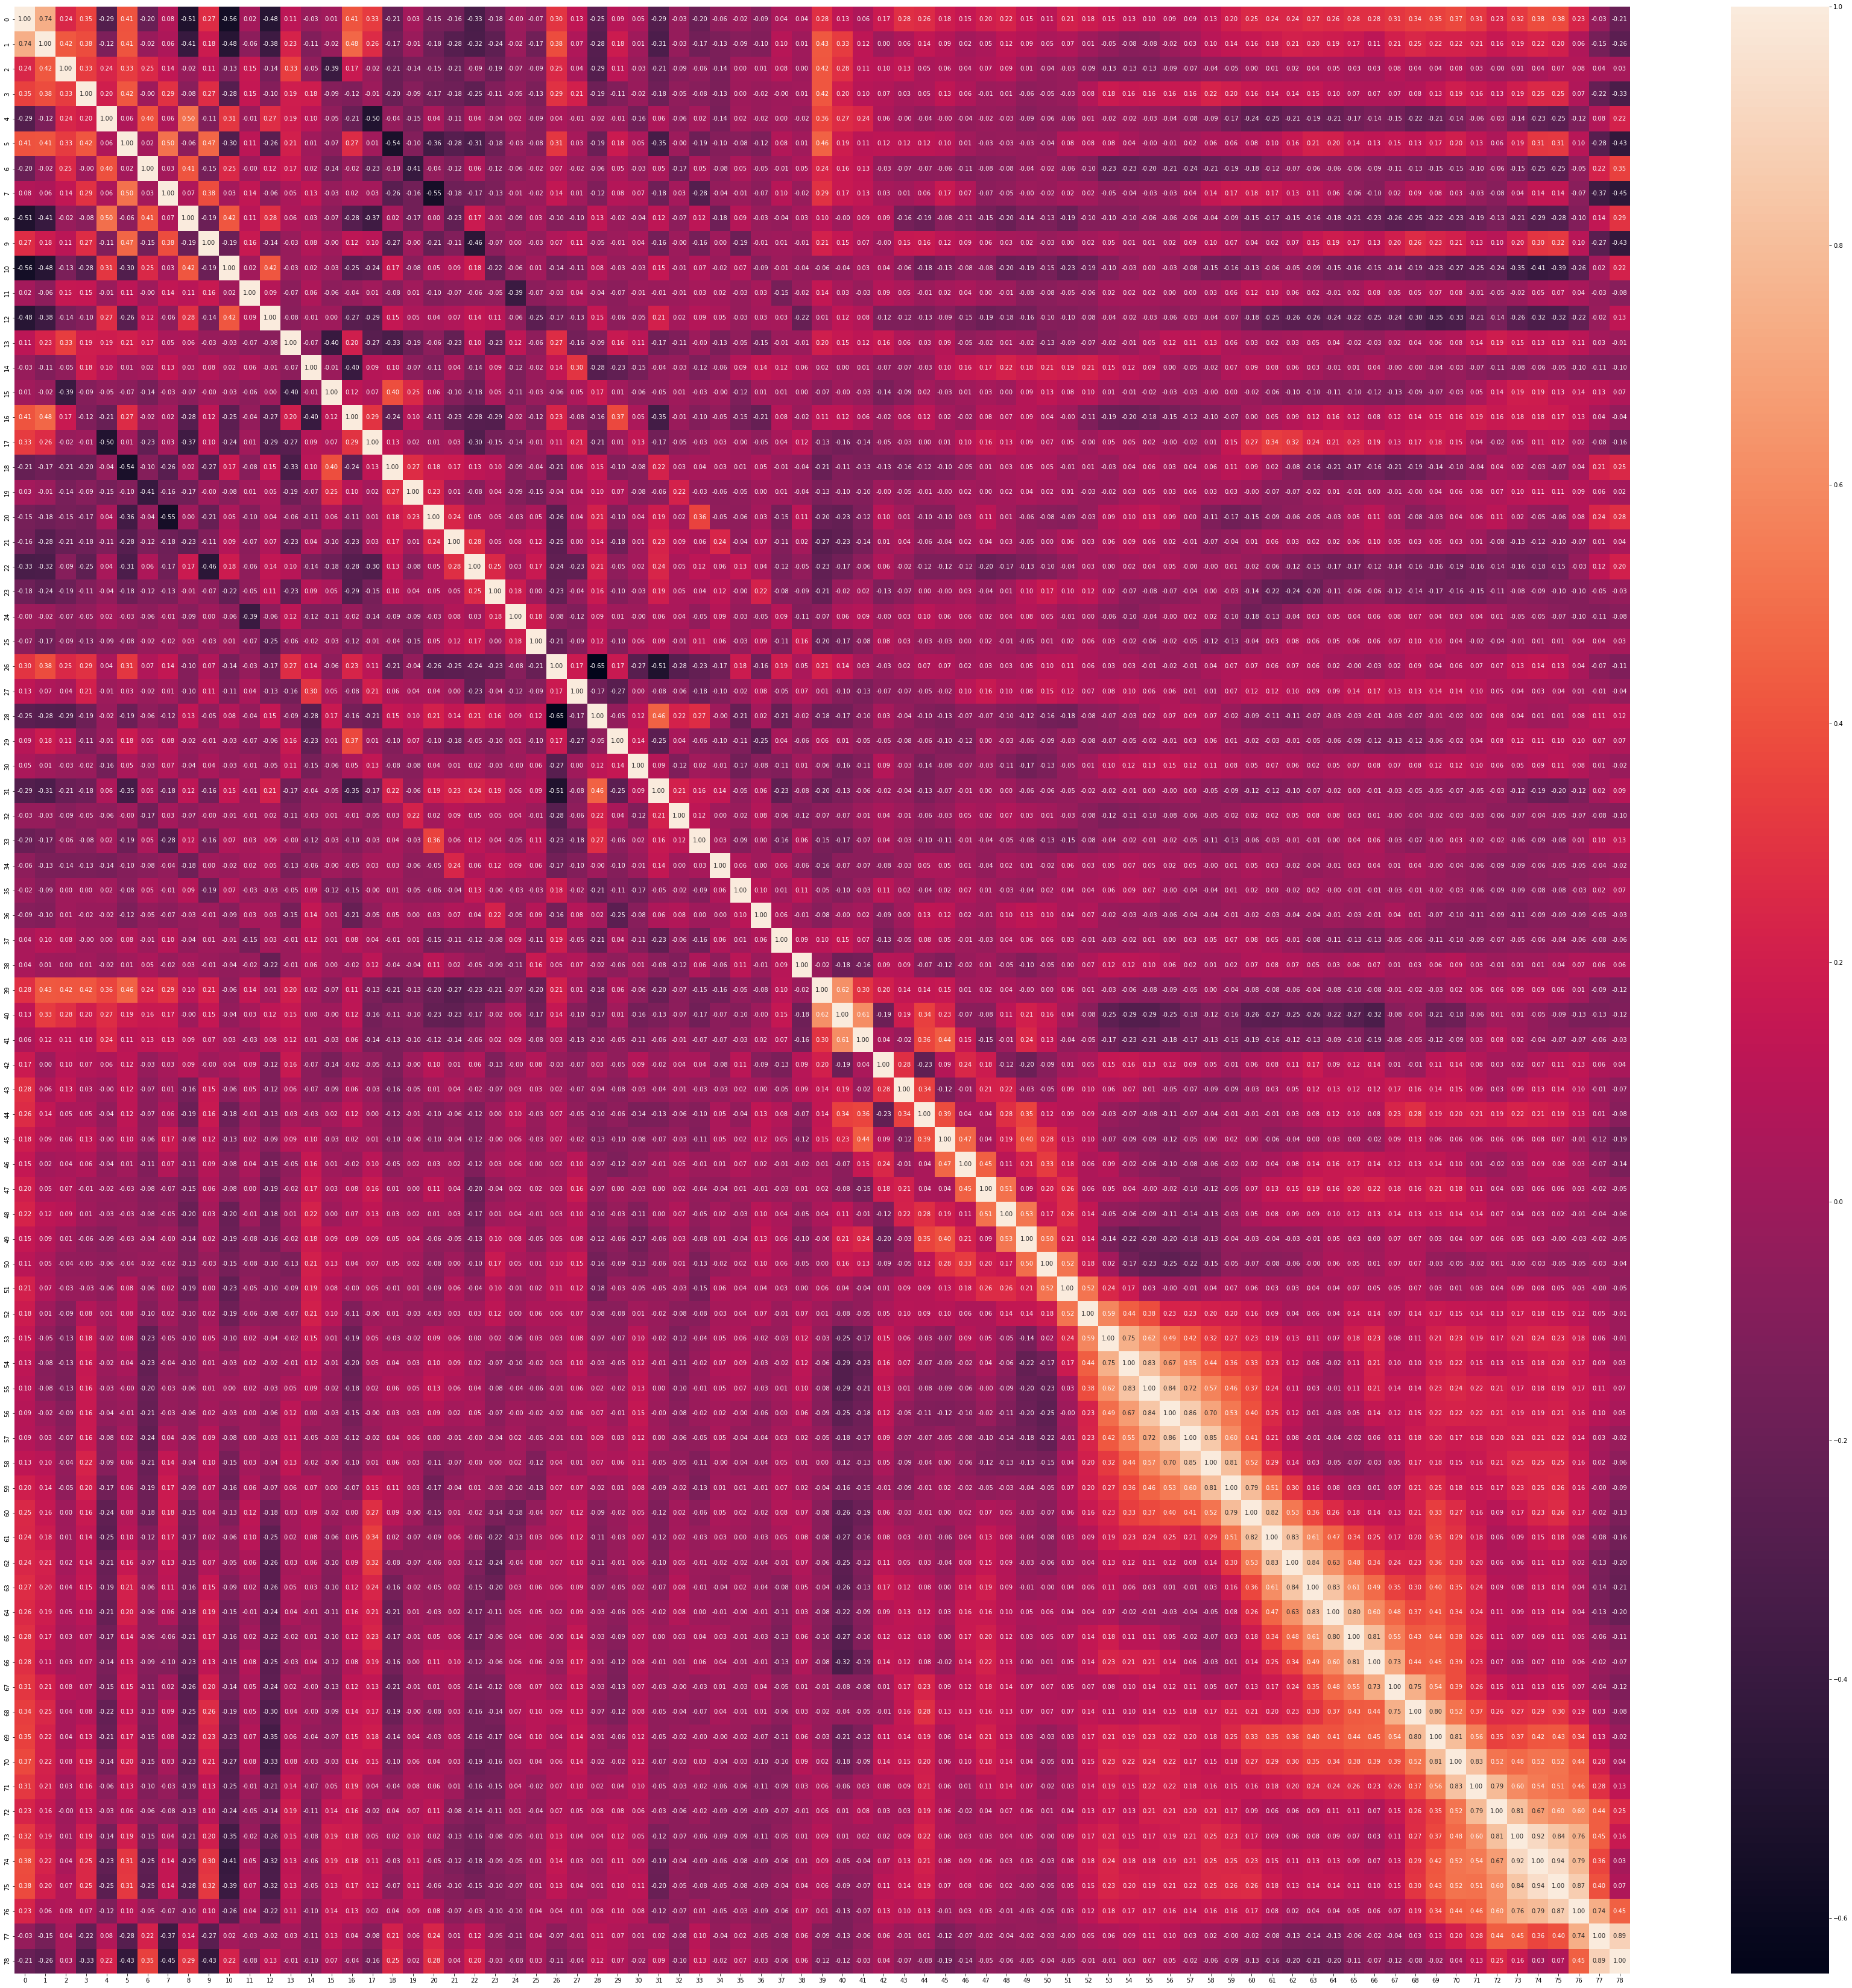

In [ ]:
import seaborn as sns # Visualización de datos de manera más gráfica
# Aquí se está realizando un heatmap para ver la correlación entre las características
fig, ax = plt.subplots(figsize=(60, 60))
correlacion_n = df_dataset.corr(method="spearman")
sns.heatmap(correlacion_n,annot=True, fmt=".2f")
plt.show()

# Modelo

In [ ]:
# Crear clasificador con los parámetros dados
clf = RandomForestClassifier(n_estimators=340, criterion='entropy', max_features='sqrt', random_state=15) #128 es un número muy lindo y 33 pero no tanto

# Entrenar el clasificador
clf.fit(x_train_P, y_train_P)

# Evaluar el clasificador en los datos de prueba
score = clf.score(x_test_P, y_test_P)
print("Exactitud: {:.2f}".format(score))

y_pred = clf.predict(x_test_P)
precision = precision_score(y_test_P, y_pred, average='micro')

print("Precisión: {:.2f}".format(precision))

Exactitud: 0.87
Precisión: 0.87


# Medición del performance

In [ ]:
# Error de test del primer modelo
# ==============================================================================
predicciones = y_pred
print(y_test_P[:])
print(predicciones[:])

[0 4 0 4 4 0 0 2 3 4 2 3 3 2 1 2 4 1 2 3 4 4 4 1 0 1 2 0 1 3 0 1 2 1 4 1 3
 2 3 1 2 3 4 3 3 1 4 1 3 2 4 2 4 3 4 1 1 0 2 4 3 4 0 2 1 3 4 2 4 1 2 1 1 3
 2 0 4 1 1 0 3 3 4 1 2 0 1 1 0 4 2 3 3 0 2 0 3 2 2 2 2 3 0 1 3 0 0 3 0 0 1
 2 0 4 3 2 1 4 3 0 4 0 2 3 0 0 4 0 4 1 4 2 1]
[0 4 0 4 4 0 1 2 2 4 2 3 3 2 1 2 4 1 2 3 4 4 1 2 0 1 2 0 1 3 1 1 2 1 4 1 3
 2 3 1 2 3 4 3 3 1 4 1 3 2 4 2 4 3 4 1 1 0 2 4 3 0 2 2 1 3 4 2 4 1 2 1 1 4
 2 0 4 1 1 0 3 3 4 4 2 4 1 1 0 4 2 3 3 0 0 0 3 2 2 2 1 3 0 1 0 0 3 3 0 0 1
 3 0 4 3 0 1 2 3 0 4 0 2 3 0 0 4 0 4 1 4 2 1]


Matriz de confusión
-------------------

El accuracy de test es: 87.21804511278195 %
El número de datos de testeo es: 133
El número de predicciones correctas es: 116


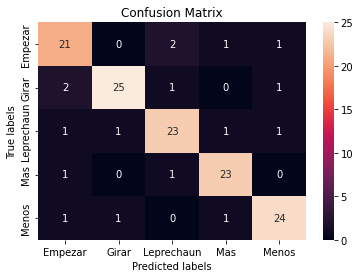

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(
            y_true    = y_test_P.ravel(),
            y_pred    = predicciones.ravel(),
            normalize = True
           )

print("Matriz de confusión")
print("-------------------")
T5_lables = ['Empezar','Girar','Leprechaun','Mas','Menos']

ax= plt.subplot()

cm = metrics.confusion_matrix(np.asarray(predicciones), np.asarray(y_test_P))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(T5_lables); ax.yaxis.set_ticklabels(T5_lables);
print("")
print(f"El accuracy de test es: {100 * accuracy} %")

num_correct = np.sum(y_test_P == predicciones)
print(f"El número de datos de testeo es: {len(y_test_P)}")
print(f"El número de predicciones correctas es: {num_correct}")

In [ ]:
result1 = metrics.classification_report(y_test_P, y_pred)
print("Classification Report:",)
print (result1)

clf.fit(x_train_P,y_train)
#plt.plot(clf.loss_curve_)
clf.fit(x_test_P,y_test)
#plt.plot(clf.loss_curve_)
plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.81      0.82        26
           1       0.86      0.93      0.89        27
           2       0.85      0.85      0.85        27
           3       0.92      0.88      0.90        26
           4       0.89      0.89      0.89        27

    accuracy                           0.87       133
   macro avg       0.87      0.87      0.87       133
weighted avg       0.87      0.87      0.87       133



# Guardar el modelo

In [ ]:
import joblib
# Guardar el modelo en un archivo con pickle
# with open('modelo_random_forest_087.h5', 'wb') as f:
#     joblib.dump(clf, f)

In [ ]:
joblib.dump(clf,"MODELOJOBLIB.sav")

['MODELOJOBLIB.sav']